In [1]:
%matplotlib inline
import proplot as pplt # plotting
import numpy as np # might be useful
import pandas as pd # for reading the csv files
import datetime as dt # for date handling
#import PyCO2SYS as pyco2 # Carbon Chemistry
import BG.readDat as rd # reading the files
from datetime import datetime
#import cftime as cft
import xarray as xr
from matplotlib import pyplot as plt
import cartopy.feature as cfeature
import os
ncds = xr.open_dataset('DATA/NAA_Area_Volume.nc') # read a file that contatis NAA info
glodap = xr.open_dataset('DATA/OBS/GLODAP/data_from_GLODAPv2.2022/data_from_GLODAPv2.2022.nc') 
# read the textfile to rename the variables:
rename = pd.read_csv('DATA/OBS/GLODAP/data_from_GLODAPv2.2022/data_from_GLODAPv2.2022_nc_variables.txt', sep = '\t')
# Rename the variables to sth meaningful
for i in range(0,len(rename)):
  try: glodap = glodap.rename({rename.iloc[i][0]: rename.iloc[i][1]})
  except: print(rename.iloc[i][0])

glodap = glodap.rename({'var13': 'pH~_T2'	 })  
#glodap  

dont_chng   date_time
nan
var13


In [2]:
# For getting Depth Values
ncds = xr.open_dataset('DATA/NAA_Area_Volume.nc') # this is the updated file with corrected depth cut-offs 
z = [0]
zc  = list(ncds.z_cuts.values)
zcu = z + zc
d = ncds.deptht.values


In [3]:
glodap = glodap.drop_vars(['var4_info','var5_info','var6_info','var7_info','var8_info',
                           'var11_info','var10_info','var13_info'])

In [4]:
glodap = glodap.drop_vars(['Alias Cruise Names', 'Type','Ship', 'Chief Scientist', 'Carbon PI', 'Hydrography PI', 'Oxygen PI', 'Nutrients PI', 'CFC PI',
 'Organics PI', 'Isotopes PI', 'Other PI', 'Cruise Metadata'])

In [5]:
glodap['Longitude'].min()

<xarray.DataArray 'Longitude' ()>
array(0.)

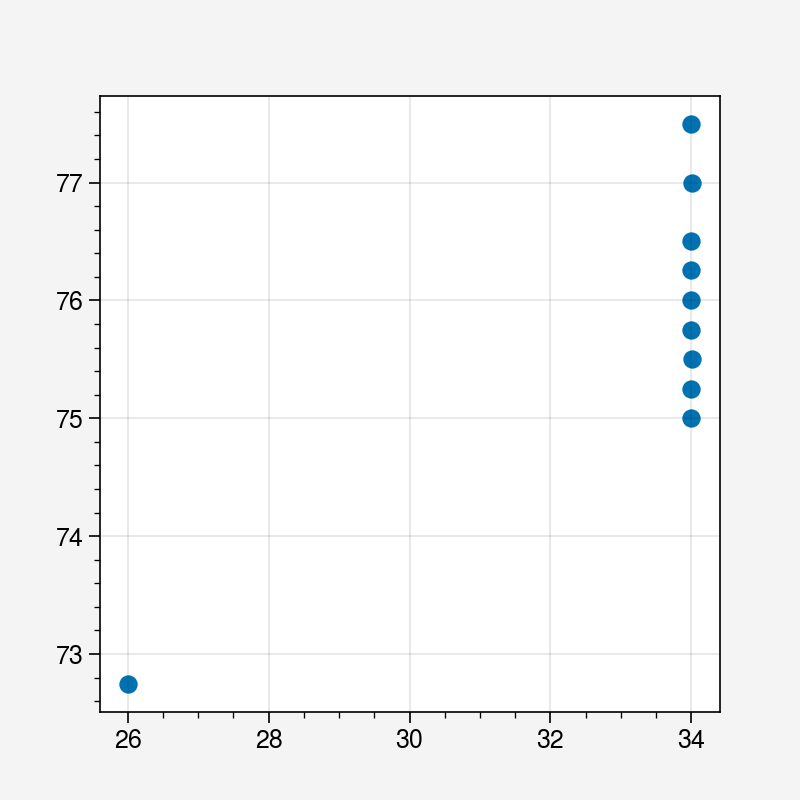

In [6]:
plt.scatter(glodap['Longitude'][:10], glodap['Latitude'][:10])

In [7]:
glodap['Longitude'][-10]

<xarray.DataArray 'Longitude' ()>
array(328.586, dtype=float32)
Attributes:
    long_name:       Longitude
    standard_name:   longitude
    units:           degrees_east
    comment:         
    C_format:        %.3f
    FORTRAN_format:  F12.3

'\nZero point is Greenich, then increasing values eastwards.\n'

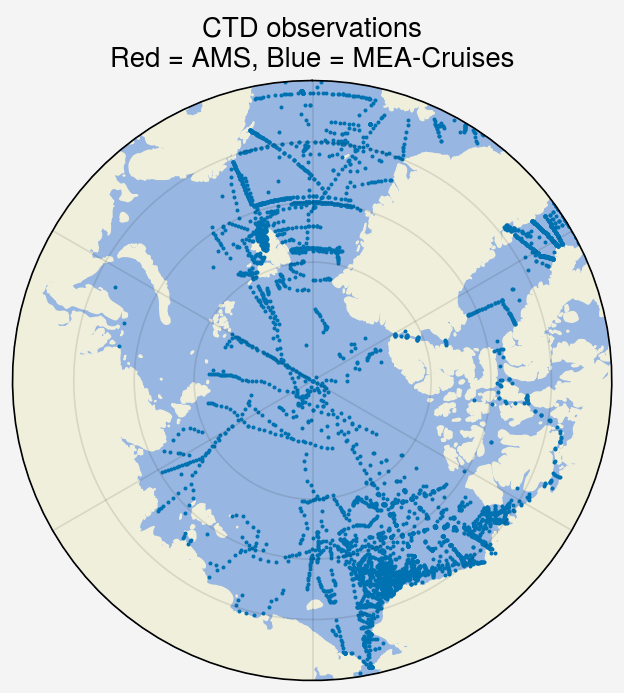

In [8]:
#h = [120,121,122,123,124,125]
proj = pplt.Proj('npstere', central_longitude=-180,)
fig, axm = pplt.subplots(axwidth=3, axheight=3, proj=proj)
axm.format( land=False, lonlabels='t', latlabels='l', boundinglat = 65 , #lonlim=(-180, 180), latlim=(50, 90),
           title = 'CTD observations\nRed = AMS, Blue = MEA-Cruises')
axm.add_feature(cfeature.OCEAN)
axm.add_feature(cfeature.LAND)
axm.scatter(glodap.Longitude,glodap.Latitude, s = 0.7)#  c = glodap.var3.mean(dim= 'N_SAMPLES').transpose()
#print(glodap['Longitude'])
'''
Zero point is Greenich, then increasing values eastwards.
'''
# i need to change the longitude bc NEMO uses [+-180]. why does the procection not work for this now? 

In [9]:
# task: convert the Longitude from [360] to [+-180]
#glodap['Longitude']= glodap['Longitude']-360
# It needs to be more sophisticated that this... ? 
for h in range(0,len(glodap['Longitude'])): 
  if glodap['Longitude'][h] > 180:
     glodap['Longitude'][h] = glodap['Longitude'][h]-360
  else: pass
  
# now its properly rotated :)     
    

'\nZero point is Greenich, then increasing values eastwards.\n'

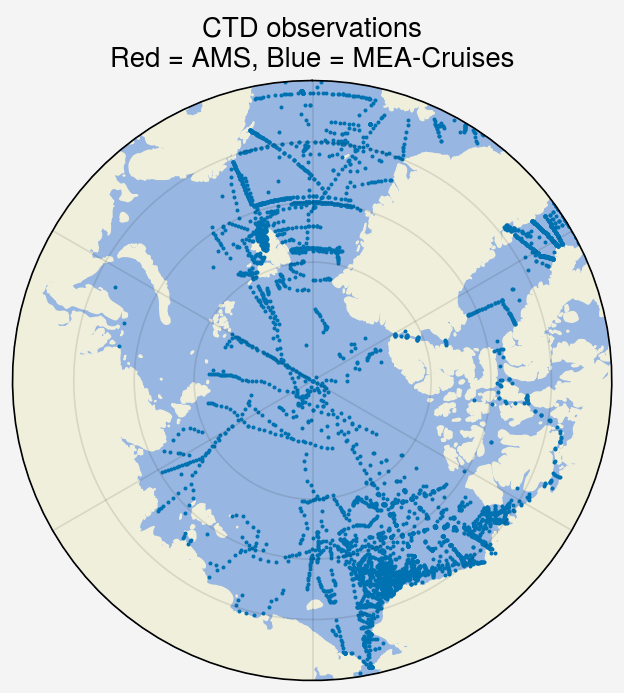

In [10]:
proj = pplt.Proj('npstere', central_longitude=-180,)
fig, axm = pplt.subplots(axwidth=3, axheight=3, proj=proj)
axm.format( land=False, lonlabels='t', latlabels='l', boundinglat = 65 , #lonlim=(-180, 180), latlim=(50, 90),
           title = 'CTD observations\nRed = AMS, Blue = MEA-Cruises')
axm.add_feature(cfeature.OCEAN)
axm.add_feature(cfeature.LAND)
axm.scatter(glodap.Longitude,glodap.Latitude, s = 0.7)#  c = glodap.var3.mean(dim= 'N_SAMPLES').transpose()
#print(glodap['Longitude'])
'''
Zero point is Greenich, then increasing values eastwards.
'''

In [11]:
# for every row in dataframe, find the griddcell index in the dataset
from gridcellfinder import gridcellfinder as gridcellfinder
from LonLatCleaner import LonLat_cleaner as LonLat_cleaner 


In [12]:
# get the NAA gridcells
glodap['lons']=glodap['Longitude'].round(2)
glodap['lats'] = glodap['Latitude'].round(2)
glodap['lonmin'] = glodap['lons'] - 0.1 #0.1 in degrees is appox 10 km -> i read in  Roberts(?) 2022 paper, they did the same
glodap['lonmax'] = glodap['lons'] + 0.1
glodap['latmin'] = glodap['lats']- 0.1
glodap['latmax'] = glodap['lats'] + 0.1
 
gcl = pd.DataFrame( columns=['X', 'Y', 'lenx', 'leny'])
for i in [*range(0,len(glodap['lons']),1)]: 
  x,y = gridcellfinder(glodap, ncds, i)
  X = x.tolist()
  Y = y.tolist()
  lenx = len(X)
  leny = len(Y)
  gcl.loc[len(gcl.index)] = [str(X), str(Y), lenx,leny]  
  
  

glodap['X_NAA'] = ('N_STATIONS', gcl['X'])
glodap['Y_NAA'] = ('N_STATIONS', gcl['Y'])
glodap['lenx'] =  ('N_STATIONS',gcl['lenx'])
glodap['leny'] =  ('N_STATIONS',gcl['leny'])
glodap  

<xarray.Dataset>
Dimensions:          (N_STATIONS: 5563, N_SAMPLES: 253)
Dimensions without coordinates: N_STATIONS, N_SAMPLES
Data variables: (12/56)
    Cruise           (N_STATIONS) |S12 ...
    Station          (N_STATIONS) |S20 ...
    Longitude        (N_STATIONS) float32 26.01 34.0 34.0 ... -30.75 -30.66
    Latitude         (N_STATIONS) float32 72.75 75.0 75.25 ... 65.17 65.08 65.0
    Bot. Depth       (N_STATIONS) float32 ...
    date_time        (N_STATIONS) datetime64[ns] ...
    ...               ...
    latmin           (N_STATIONS) float32 72.65 74.9 75.15 ... 65.07 64.98 64.9
    latmax           (N_STATIONS) float32 72.85 75.1 75.35 ... 65.27 65.18 65.1
    X_NAA            (N_STATIONS) object '[357]' '[333]' ... '[440]' '[441]'
    Y_NAA            (N_STATIONS) object '[317]' '[320]' ... '[167]' '[167]'
    lenx             (N_STATIONS) object 1 1 1 0 0 0 0 1 2 ... 1 0 1 2 2 2 1 1 1
    leny             (N_STATIONS) object 1 1 1 0 0 0 0 1 2 ... 1 0 1 2 2 2 1 1 1
Attributes:
    Conventions:         CF-1.7
    comment:             ODV NetCDF Export File V2.0
    Creator:             rschlitz@fu-00149
    CreateTime:          2022-10-14T21:32:02
    Software:            Web Ocean Data View 5.6.3 - web_server: 32 - 64 bit ...
    source:              /homelocal/rschlitz/data/ocean/hydrography/glodap/GL...
    SourceLastModified:  2022-08-06T12:33:03
    DataField:           Ocean
    DataType:            Profiles
    Description:         Hydrographic and carbon data for the global ocean (G...
    featureType:         profile

In [13]:
goo = glodap['Cruise'].values # + '_' + str(gldp['Station'].values)
boo = glodap['Station'].values

foo = []
for i in range(0,len(goo)): 
  foo.append(goo[i].decode()+ '_' + boo[i].decode() ) # decode to get the bytestring out (b'gihoirtgh')

 
#assign StationID consistent with other scripts:
glodap['Stat_id'] = glodap['date_time'].dt.strftime('%Y')+'-'+glodap['date_time'].dt.strftime('%m')  +'_GLODAP_CDT_' + foo
glodap=glodap.drop_vars(['Cruise','Station'])
glodap

<xarray.Dataset>
Dimensions:          (N_STATIONS: 5563, N_SAMPLES: 253)
Dimensions without coordinates: N_STATIONS, N_SAMPLES
Data variables: (12/55)
    Longitude        (N_STATIONS) float32 26.01 34.0 34.0 ... -30.75 -30.66
    Latitude         (N_STATIONS) float32 72.75 75.0 75.25 ... 65.17 65.08 65.0
    Bot. Depth       (N_STATIONS) float32 272.0 180.0 ... 1.764e+03 1.908e+03
    date_time        (N_STATIONS) datetime64[ns] 2007-07-29T15:45:00 ... 2003...
    PRESSURE         (N_STATIONS, N_SAMPLES) float32 ...
    var1_qc          (N_STATIONS, N_SAMPLES) float32 ...
    ...               ...
    latmax           (N_STATIONS) float32 72.85 75.1 75.35 ... 65.27 65.18 65.1
    X_NAA            (N_STATIONS) object '[357]' '[333]' ... '[440]' '[441]'
    Y_NAA            (N_STATIONS) object '[317]' '[320]' ... '[167]' '[167]'
    lenx             (N_STATIONS) object 1 1 1 0 0 0 0 1 2 ... 1 0 1 2 2 2 1 1 1
    leny             (N_STATIONS) object 1 1 1 0 0 0 0 1 2 ... 1 0 1 2 2 2 1 1 1
    Stat_id          (N_STATIONS) object '2007-07_GLODAP_CDT_06AQ20070728_227...
Attributes:
    Conventions:         CF-1.7
    comment:             ODV NetCDF Export File V2.0
    Creator:             rschlitz@fu-00149
    CreateTime:          2022-10-14T21:32:02
    Software:            Web Ocean Data View 5.6.3 - web_server: 32 - 64 bit ...
    source:              /homelocal/rschlitz/data/ocean/hydrography/glodap/GL...
    SourceLastModified:  2022-08-06T12:33:03
    DataField:           Ocean
    DataType:            Profiles
    Description:         Hydrographic and carbon data for the global ocean (G...
    featureType:         profile

In [14]:
# Group to NAA-Depth level!

# Cleaned up work-around for the problem with 1 Dimensional variables (per slice)
def binner(ds = glodap, i = 0, varlist = [] ): 
  # Depth Bins
  slce = ds.isel(N_STATIONS = i)
  oneD = slce[varlist]
  twoD = slce.drop_vars(varlist)
  try: 
    new_ds = twoD.groupby_bins(slce.DEPTH, bins = zcu, labels = d).mean()
    fu = xr.merge([new_ds, oneD])
    fu = fu.assign_coords(Stat_id= (oneD['Stat_id'].data))
    fu = fu.rename({'DEPTH_bins': 'NAA_Deptht'})
  except: 
    fu = oneD
    fu = fu.assign_coords(Stat_id= (oneD['Stat_id'].data), 
                          NAA_Deptht = d )
    # explanation: in some observations, the Depth levels "don't match the bins "
    # i was not able to find out why.
    #fu = fu.rename({'DEPTH_bins': 'NAA_Deptht'})
  return(fu)


In [15]:
blurb = glodap.drop_dims('N_SAMPLES')
v_list = list(blurb)
v_list

['Longitude',
 'Latitude',
 'Bot. Depth',
 'date_time',
 'lons',
 'lats',
 'lonmin',
 'lonmax',
 'latmin',
 'latmax',
 'X_NAA',
 'Y_NAA',
 'lenx',
 'leny',
 'Stat_id']

In [16]:
# saving each obs to a single flie, otherwise somehow got a memory issue 
flist= []
for i in range(0,len(glodap.N_STATIONS)): 
  nme = str(int(glodap.N_STATIONS[i].values))
  print(i)
  ndu = binner(ds = glodap, i = i, varlist = v_list)
  ndu.to_netcdf('scratch/ndu_'+ nme + '.nc')
  flist.append('scratch/ndu_'+ nme + '.nc')
#ndu


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
#print(len(flist)) #236
# read the files again to continue
mndu = xr.open_dataset(flist[0])
for f in range(1,len(flist)): 
  nmd = xr.open_dataset(flist[f])
  try: 
    mndu = xr.concat([mndu, nmd], dim = 'Station_id')
  except: 
    print('skipped: ', f)    # loosing 8 Observations. As far as i can tell they are near Svalbard anyways
#mndu = xr.open_mfdataset(flist[1:4], combine = 'by_coords') #, dim = 'Stat_id'
mndu #combine='by_coords'

skipped:  236
skipped:  238
skipped:  239
skipped:  324
skipped:  484
skipped:  485
skipped:  486
skipped:  487


<xarray.Dataset>
Dimensions:          (NAA_Deptht: 46, Station_id: 5555)
Coordinates:
  * NAA_Deptht       (NAA_Deptht) float64 0.5487 1.973 ... 5.622e+03 5.878e+03
    Stat_id          (Station_id) <U37 '2007-07_GLODAP_CDT_06AQ20070728_227' ...
Dimensions without coordinates: Station_id
Data variables: (12/54)
    PRESSURE         (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    var1_qc          (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    DEPTH            (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    var2_qc          (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    TEMPERATURE      (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    var3_qc          (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    ...               ...
    latmin           (Station_id) float32 72.65 74.9 75.15 ... 65.07 64.98 64.9
    latmax           (Station_id) float32 72.85 75.1 75.35 ... 65.27 65.18 65.1
    X_NAA            (Station_id) <U15 '[357]' '[333]' ... '[440]' '[441]'
    Y_NAA            (Station_id) <U12 '[317]' '[320]' ... '[167]' '[167]'
    lenx             (Station_id) int64 1 1 1 0 0 0 0 1 2 ... 1 0 1 2 2 2 1 1 1
    leny             (Station_id) int64 1 1 1 0 0 0 0 1 2 ... 1 0 1 2 2 2 1 1 1

In [19]:
# remove the stations that are outside of the NAA grid
#xrds['nav_lon'].where((xrds['nav_lat'] > df['latmin'][i]) & (xrds['nav_lat'] < df['latmax'][i]) 
gldp = mndu.where((mndu['lenx']!=0 )& (mndu['leny']!=0), drop = True)
gldp

<xarray.Dataset>
Dimensions:          (Station_id: 3884, NAA_Deptht: 46)
Coordinates:
  * NAA_Deptht       (NAA_Deptht) float64 0.5487 1.973 ... 5.622e+03 5.878e+03
    Stat_id          (Station_id) <U37 '2007-07_GLODAP_CDT_06AQ20070728_227' ...
Dimensions without coordinates: Station_id
Data variables: (12/54)
    PRESSURE         (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    var1_qc          (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    DEPTH            (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    var2_qc          (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    TEMPERATURE      (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    var3_qc          (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    ...               ...
    latmin           (Station_id) float32 72.65 74.9 75.15 ... 65.07 64.98 64.9
    latmax           (Station_id) float32 72.85 75.1 75.35 ... 65.27 65.18 65.1
    X_NAA            (Station_id) object '[357]' '[333]' ... '[440]' '[441]'
    Y_NAA            (Station_id) object '[317]' '[320]' ... '[167]' '[167]'
    lenx             (Station_id) float64 1.0 1.0 1.0 1.0 ... 2.0 1.0 1.0 1.0
    leny             (Station_id) float64 1.0 1.0 1.0 1.0 ... 2.0 1.0 1.0 1.0

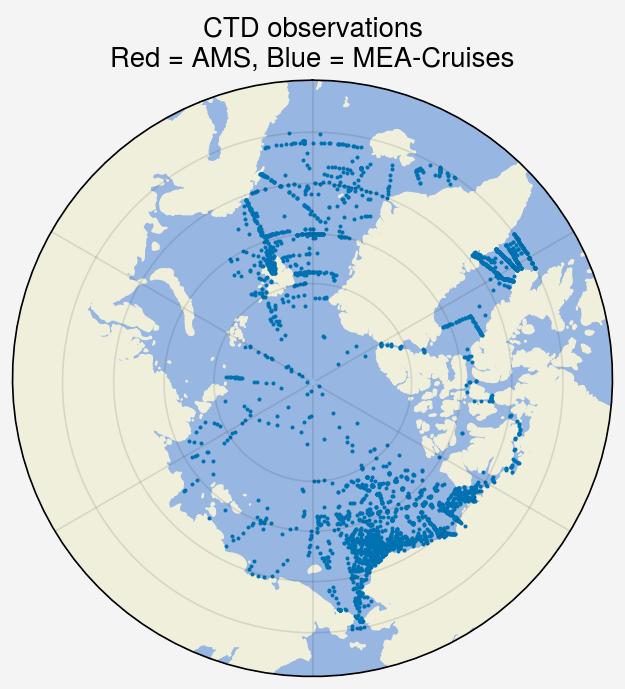

In [25]:
proj = pplt.Proj('npstere', central_longitude=-180,)
fig, axm = pplt.subplots(axwidth=3, axheight=3, proj=proj)
axm.format( land=False, lonlabels='t', latlabels='l', boundinglat = 60 , #lonlim=(-180, 180), latlim=(50, 90),
           title = 'CTD observations\nRed = AMS, Blue = MEA-Cruises')
axm.add_feature(cfeature.OCEAN)
axm.add_feature(cfeature.LAND)
axm.scatter(gldp.Longitude,gldp.Latitude, s = 0.7)#  c = glodap.var3.mean(dim= 'N_SAMPLES').transpose()

In [21]:
## update the Attributes: 
gldp.attrs = {'script': 'created with GLODAP_22.ipynb -- JLanger',
              'cluster': 'Aeolus - Uvic',
              'creation Date--time': str(datetime.now()), 
              'Data-source': 'glodap catalogue v 2.22',
              'Conventions': 'CF-1.7', 
              'Description':'Hydrographic and carbon data for the global ocean (GLODAP version v2.2022)'}
gldp

<xarray.Dataset>
Dimensions:          (Station_id: 3884, NAA_Deptht: 46)
Coordinates:
  * NAA_Deptht       (NAA_Deptht) float64 0.5487 1.973 ... 5.622e+03 5.878e+03
    Stat_id          (Station_id) <U37 '2007-07_GLODAP_CDT_06AQ20070728_227' ...
Dimensions without coordinates: Station_id
Data variables: (12/54)
    PRESSURE         (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    var1_qc          (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    DEPTH            (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    var2_qc          (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    TEMPERATURE      (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    var3_qc          (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    ...               ...
    latmin           (Station_id) float32 72.65 74.9 75.15 ... 65.07 64.98 64.9
    latmax           (Station_id) float32 72.85 75.1 75.35 ... 65.27 65.18 65.1
    X_NAA            (Station_id) object '[357]' '[333]' ... '[440]' '[441]'
    Y_NAA            (Station_id) object '[317]' '[320]' ... '[167]' '[167]'
    lenx             (Station_id) float64 1.0 1.0 1.0 1.0 ... 2.0 1.0 1.0 1.0
    leny             (Station_id) float64 1.0 1.0 1.0 1.0 ... 2.0 1.0 1.0 1.0
Attributes:
    script:               created with GLODAP_22.ipynb -- JLanger
    cluster:              Aeolus - Uvic
    creation Date--time:  2022-10-26 14:10:51.808287
    Data-source:          glodap catalogue v 2.22
    Conventions:          CF-1.7
    Description:          Hydrographic and carbon data for the global ocean (...

In [22]:
# write this version to file, pick it up again combinded with the others
gldp.to_netcdf('OUTPUT/GLODAP_22.nc')

In [23]:
gldp

<xarray.Dataset>
Dimensions:          (Station_id: 3884, NAA_Deptht: 46)
Coordinates:
  * NAA_Deptht       (NAA_Deptht) float64 0.5487 1.973 ... 5.622e+03 5.878e+03
    Stat_id          (Station_id) <U37 '2007-07_GLODAP_CDT_06AQ20070728_227' ...
Dimensions without coordinates: Station_id
Data variables: (12/54)
    PRESSURE         (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    var1_qc          (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    DEPTH            (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    var2_qc          (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    TEMPERATURE      (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    var3_qc          (Station_id, NAA_Deptht) float32 nan nan nan ... nan nan
    ...               ...
    latmin           (Station_id) float32 72.65 74.9 75.15 ... 65.07 64.98 64.9
    latmax           (Station_id) float32 72.85 75.1 75.35 ... 65.27 65.18 65.1
    X_NAA            (Station_id) object '[357]' '[333]' ... '[440]' '[441]'
    Y_NAA            (Station_id) object '[317]' '[320]' ... '[167]' '[167]'
    lenx             (Station_id) float64 1.0 1.0 1.0 1.0 ... 2.0 1.0 1.0 1.0
    leny             (Station_id) float64 1.0 1.0 1.0 1.0 ... 2.0 1.0 1.0 1.0
Attributes:
    script:               created with GLODAP_22.ipynb -- JLanger
    cluster:              Aeolus - Uvic
    creation Date--time:  2022-10-26 14:10:51.808287
    Data-source:          glodap catalogue v 2.22
    Conventions:          CF-1.7
    Description:          Hydrographic and carbon data for the global ocean (...